#Analysis and display of Data from the Sensor Box

This script is used to read, analysis, display, and export data collected using the sensor box.

**Packages:**

In [35]:
#Data handling
import numpy as np
import pandas as pd
import simplejson as json
from splitstream import splitfile

#Timestamp handling
from datetime import datetime

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import dates as mdates
from matplotlib.ticker import LinearLocator

**Loading JSON file, line by line:**

In [36]:
with file("particle_log.log") as f:
    dat = []
    for line in splitfile(f, format="json"):
        buf = json.loads(line)
        dat.append(buf)

measurements = []
date = []
date_format = '%Y-%m-%dT%H:%M:%S.%fZ'

for it in range(0,len(dat)):
#while True:
    try:
        measurements.append([float(val) for val in dat[it]['data'].split(",")])
        date.append(datetime.strptime(dat[it]['published_at'], date_format))
    except:
        continue
        
data = np.array([xi+[None]*(4-len(xi)) for xi in measurements])

**Create a pandas data frame for easy indexing using a datetime timestamp:**

The mean temperature was: 21.2(0.8).
The mean light was: 496.6(206.0).
The mean movement was: 0.2(0.4).
The mean noise was: 2799.9(49.6).


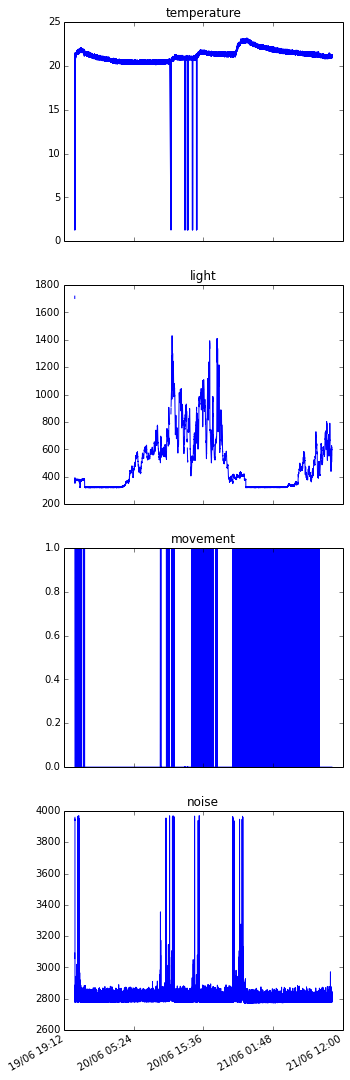

In [48]:
frame = pd.DataFrame(measurements,index=date,columns=["temperature","light","movement","noise"])

time1 = "2015-06-19T06:00:00.000Z"
time2 = "2015-06-22T06:00:00.000Z"

start = datetime.strptime(time1,date_format)
end = datetime.strptime(time2,date_format)

#PLOT
params = ["temperature","light","movement","noise"]
hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5,20))

for para,i in zip(params,range(len(params))):
    axs[i].plot(frame[para][start:end].index,frame[para][start:end].values)
    axs[i].set_title(para)
    axs[i].xaxis.set_major_formatter(hfmt)
    axs[i].xaxis.set_major_locator(LinearLocator(numticks=5))
    print "The mean %s was: %.1f(%.1f)." % (para,frame[para][start:end].describe()["mean"],frame[para][start:end].describe()["std"])

fig.autofmt_xdate()

**Simple Gauss filter of the data, first noise:**

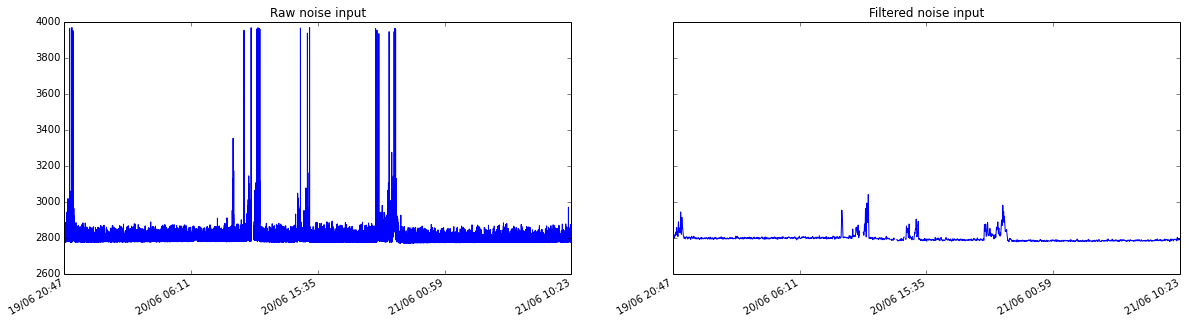

In [44]:
from scipy.signal import gaussian
from scipy.ndimage import filters

def Gauss_filt(y):
    b = gaussian(39, 10)
    ga = filters.convolve1d(y, b/b.sum())
    return ga

#NOISE
para = "noise"
ga_noise = Gauss_filt(frame[para][start:end].values)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,5))
hfmt = mdates.DateFormatter('%d/%m %H:%M')

axs[0].plot(frame[para][start:end].index,frame[para][start:end].values)
axs[1].plot(frame[para][start:end].index,ga_noise)

axs[0].set_title("Raw noise input")
axs[1].set_title("Filtered noise input")

for i in range(2):
    axs[i].xaxis.set_major_formatter(hfmt)
    axs[i].xaxis.set_major_locator(LinearLocator(numticks=5))

fig.autofmt_xdate()

**Filter the light signal:**

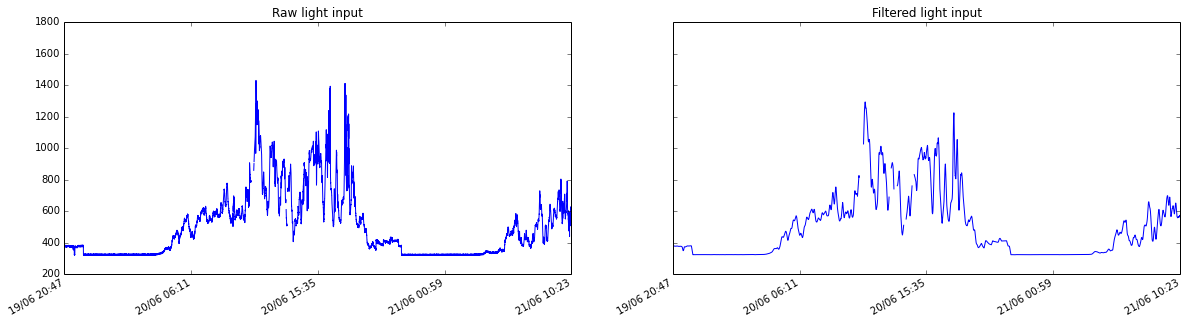

In [45]:
from scipy.signal import butter, gaussian, filtfilt
from scipy.ndimage import filters

def testGauss(y):
    b = gaussian(80, 40)
    ga = filters.convolve1d(y, b/b.sum())
    return ga

para = "light"

ga_light = testGauss(frame[para][start:end].values)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,5))
hfmt = mdates.DateFormatter('%d/%m %H:%M')

axs[0].plot(frame[start:end].index,frame[para][start:end].values)
axs[1].plot(frame[start:end].index,ga_light)

axs[0].set_title("Raw light input")
axs[1].set_title("Filtered light input")

for i in range(2):
    axs[i].xaxis.set_major_formatter(hfmt)
    axs[i].xaxis.set_major_locator(LinearLocator(numticks=5))

fig.autofmt_xdate()

**Normalise light and noise signal:**

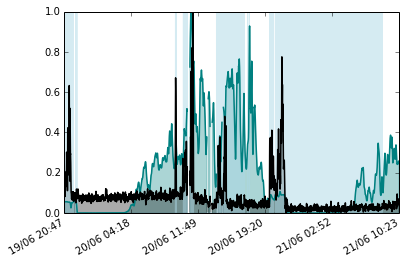

In [46]:
light_norm = (ga_light-np.nanmin(ga_light))/(np.nanmax(ga_light)-np.nanmin(ga_light))
noise_norm = (ga_noise-np.nanmin(ga_noise))/(np.nanmax(ga_noise)-np.nanmin(ga_noise))


fig, ax = plt.subplots()

ax.plot(frame[start:end].index,frame["movement"][start:end].values,color='lightblue',alpha=.5)
ax.plot(frame[start:end].index,light_norm,color='teal',linewidth=1.5)
ax.plot(frame[start:end].index,noise_norm,color='black',linewidth=1.5)

ax.fill_between(frame[start:end].index,0,light_norm,color="teal", alpha=0.33)
ax.fill_between(frame[para][start:end].index,0,noise_norm,color="black", alpha=0.33)

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
ax.xaxis.set_major_locator(LinearLocator(numticks=6))
ax.xaxis.set_major_formatter(hfmt)

**Turn noise and light signal into a simple wavefunction with values 0,1 using a treshold value:**

(0, 1)

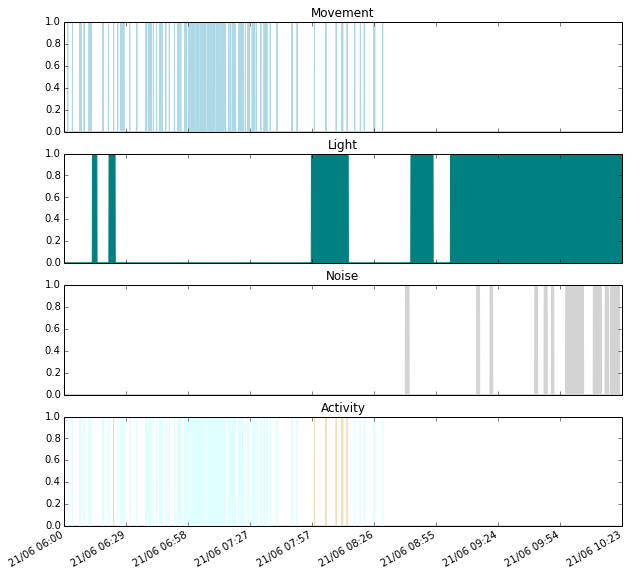

In [42]:
line_light = [1 if x>0.5 else 0 for x in light_norm]
line_noise = [1 if x>0.5 else 0 for x in noise_norm]
line_movement = frame["movement"][start:end].values

day_active_high = [1 if (x==1 and y==1 and z==1) else 0 for (x,y,z) in zip(line_light,line_noise,line_movement)]
day_active_low = [1 if (x==1 and y==0 and z==1) else 0 for (x,y,z) in zip(line_light,line_noise,line_movement)]
night_active_high = [1 if (x==0 and y==1 and z==1) else 0 for (x,y,z) in zip(line_light,line_noise,line_movement)]
night_active_low = [1 if (x==0 and y==0 and z==1) else 0 for (x,y,z) in zip(line_light,line_noise,line_movement)]

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10,10))

axs[0].fill_between(frame[start:end].index,0,line_movement,color="lightblue")
axs[1].fill_between(frame[start:end].index,0,line_light,color="teal")
axs[2].fill_between(frame[start:end].index,0,line_noise,color="lightgray")

axs[3].fill_between(frame[start:end].index,0,day_active_high,color="orange")
axs[3].fill_between(frame[start:end].index,0,day_active_low,color="wheat")
axs[3].fill_between(frame[start:end].index,0,night_active_high,color="darkcyan")
axs[3].fill_between(frame[start:end].index,0,night_active_low,color="lightcyan")

axs[0].set_title("Movement")
axs[1].set_title("Light")
axs[2].set_title("Noise")
axs[3].set_title("Activity")

hfmt = mdates.DateFormatter('%d/%m %H:%M')

fig.autofmt_xdate()
axs[0].xaxis.set_major_locator(LinearLocator(numticks=10))
axs[0].xaxis.set_major_formatter(hfmt)
axs[0].set_ylim((0,1))